### Abstract

## Novel Phases of Copper Phosphides from Computational Structure Searches

Using first principles structure searching we have predicted a novel high-capacity conversion anode within the Cu-P family, and identified metastable structures within the Cu-P phase diagram. We identify and characterize structures within the Cu-P family using density-functional theory. From these searches, we identify a novel $Fm\bar{3}m$ phase of Cu$_2$P and two metastable structures, an $I\bar{4}3d$ Cu$_3$P phase and $Cm$ Cu$_3$P$_11$ phase. Electronic band structure and density of states calculations show that Cu$_2$P has similar electronic properties to both Ir$_2$P and Rh$_2$P, with dispersive metal bands around the Fermi level, and a high density of transition-metal $d$ states 2-3 eV below the Fermi level. Pair-distribution functions of the novel $Cm$ Cu$_3$P$_{11}$ phase show its structural similarity to the known $Cm$ Cu$_2$P$_7$ phase.  By calculating the free energy of all phases on the Cu-P convex hull including vibrational effects we create a finite-temperature phase diagram which predicts $Fm\bar{3}m$ Cu$_2$P to be stable at room temperature. The finite-temperature phase diagram also predicts the Cu$_{3-x}$P ($x<1$) defect phase $Cmc2_1$ Cu$_8$P$_3$ to be stable at room temperature. This extensive characterization of the Cu-phosphide family has applications in field of Li-ion batteries, as both CuP$_2$ and Cu$_3$P have been previously used as Li-ion battery conversion anodes with capacities higher than graphite. Cu$_2$P has a theoretical Li gravimetric capacity of 508 mAh/g, higher than both Cu$_3$P and graphite, suggesting its use for future conversion anodes. 

### Imports

In [1]:
from matador.config.config import set_settings
set_settings(
    {
        'plotting': {
            'element_colours': './config/vesta_elements.ini',
            'default_style': ['matador', './config/CuP.mplstyle']
        }
    }
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tqdm
import glob
import pickle

import numpy as np    
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# ME: revert to png here for now to save space
set_matplotlib_formats('png')

from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict, res2dict
from matador.utils.cursor_utils import filter_unique_structures
from matador.utils.cell_utils import standardize_doc_cell, get_spacegroup_spg
from matador.utils.chem_utils import get_formula_from_stoich


## Results

### Convex hull from structure prediction

In [3]:
# load AIRSS structures obtained from searching (old)
cursor, failures = res2dict('/u/fs1/afh41/proj/Cu+P/hull-CuP500501-afh41-LiCuP-polish1/*.res', db=True)

if failures:
    print(failures)

In [4]:
# do some pruning: reevaluate symmetries and reduce cells
cursor = [standardize_doc_cell(doc, ) for doc in cursor]
for doc in cursor:
    doc['space_group'] = get_spacegroup_spg(doc, symprec=0.01)

In [5]:
# filter them for uniqueness to retain 44 structures
filtering = True
if filtering:
    polished_cursor = filter_unique_structures(cursor, sim_tol=0.1, enforce_same_stoich=True,
                                               quiet=True)
else:
    polished_cursor = cursor

Calculating fingerprints...
Assessing similarities...
Skipping 12 structures out of 241 as no comparisons are required
Running 229 jobs on at most 6 processes, set by core count.
Applying hierarchy of structures with order: ['ICSD', 'DOI', 'OQMD', 'MP', 'PF', 'SWAPS', 'AIRSS', 'GA']
Done!
Filtered 241 down to 44


In [6]:
polished_hull = QueryConvexHull(
    cursor=polished_cursor, 
    species=['Cu', 'P'], 
    no_plot=True
)

6 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0[..]             -0.00       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]              0.01       41.6          0.0    Fm-3m         Cu2P         1     SWAPS  
* CuP2-OQMD_6538-CollCode35282_3[..]              0.05       48.9          0.0   P2_1/c         CuP2         4      ICSD  
* Cu2P7-OQMD_6537-CollCode35281_0                -0.08      163.3          0.0    C2/m          Cu2P7 

Using config from /u/fs1/afh41/.matadorrc


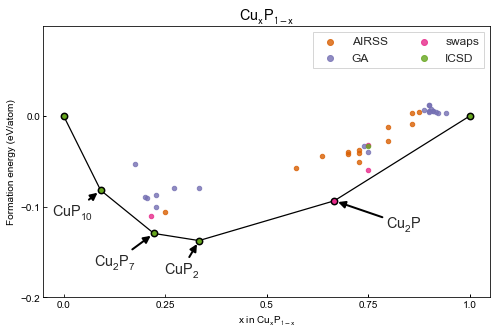

In [7]:
from matador.plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_2d_hull(
    polished_hull,
    ax=ax,
    label_cutoff=8e-3, 
    colour_by_source=True,
    hull_cutoff=0.01,
    plot_hull_points=False,
    show=False,
    alpha=0.8, 
    label_offset=(1.15, 0.02),
    eform_limits=(-0.2, 0.1),
    sources=['AIRSS', 'GA', 'SWAPS', 'ICSD','OQMD'],
    source_labels=['AIRSS', 'GA','swaps','ICSD','OQMD']
)
ax.set_yticks([-0.2, -0.1, 0])
ax.tick_params(direction='in')
plt.savefig('CuP-convex-hull.png',bbox_inches='tight',transparent=True)

In [8]:
from matador.utils.cursor_utils import display_results
# Print a table of all the structures with negative formation energy which are also within 50 meV of hull
# currently "summary" means it takes the best structure at each stoich
table_args = {'hull': True, 'summary': False,'use_source': True}

table_cursor = [doc for doc in polished_hull.cursor if doc['hull_distance'] <= 0.05 and doc['formation_enthalpy'] <= 0]
display_results(table_cursor, **table_args)
latex_table = display_results(table_cursor, latex=True, return_str=True, **table_args)
# replace caps "SWAPS" with "swaps"
latex_table = latex_table.replace("SWAPS", "swaps")
with open('CuP_table.tex', 'w') as f:
    f.write(latex_table)

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0[..]             -0.00       11.9          0.0    Fm-3m          Cu          1      ICSD  
  CuP_ratios-anbf0moptimised                     -0.02       44.7         31.3   I4/mmm         Cu6P         2     AIRSS  
  CuP_ratios-kzw2kyoptimised                     -0.05       65.6         28.2   P4/nmm         Cu4P         2     AIRSS  
  CuP_ratios-ty38s2optimised                      0.02       65.5         43.9    Cmmm          Cu4P         1     AIRSS  
  Cu3P-swap-AsCu3-OQMD_11878-Col[..]             -0.04  

### Cu$_2$P electronic structure and dynamic stability

### Structural similarity between CuP$_2$, Cu$_3$P$_{11}$ and Cu$_2$P$_7$

Using config from /u/fs1/afh41/.matadorrc


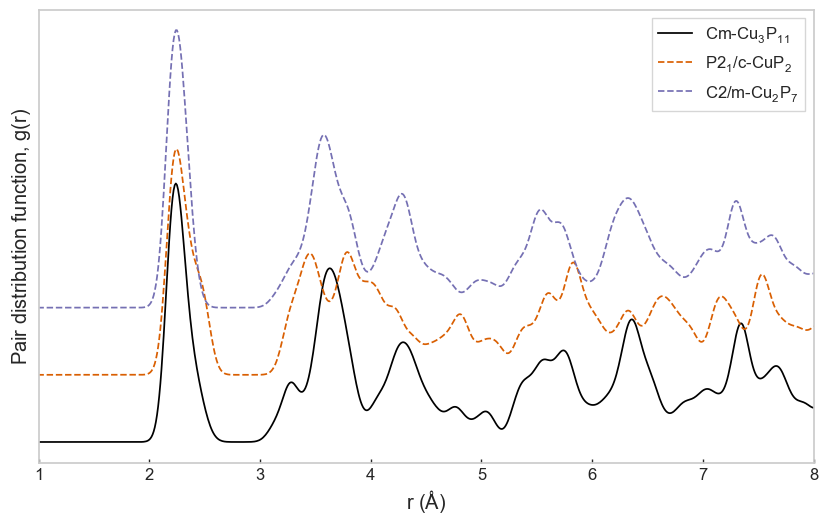

In [9]:
from matador.utils.cell_utils import get_space_group_label_latex
from matador.crystal import Crystal
from matador.plotting import plot_pdf, plot_projected_pdf
cursor, failures = res2dict('/u/fs1/afh41/query-Cu3P11-afh41-LiCuP-polish/*.res', as_model=True)
cursor = [Crystal(doc) for doc in cursor]
Cu3P11 = cursor.pop(2)
cursor.insert(0,Cu3P11)
labels=[get_space_group_label_latex(get_spacegroup_spg(doc, symprec=0.01)).replace("\\text", "")+
        '-'+get_formula_from_stoich(doc['stoichiometry'],tex=True) for doc in cursor]
plot_pdf(cursor[0].pdf, other_pdfs=[doc.pdf for doc in cursor[1:]],
         maxr=8,offset=20,
         labels=labels,
        png=True
        )

Using config from /u/fs1/afh41/.matadorrc


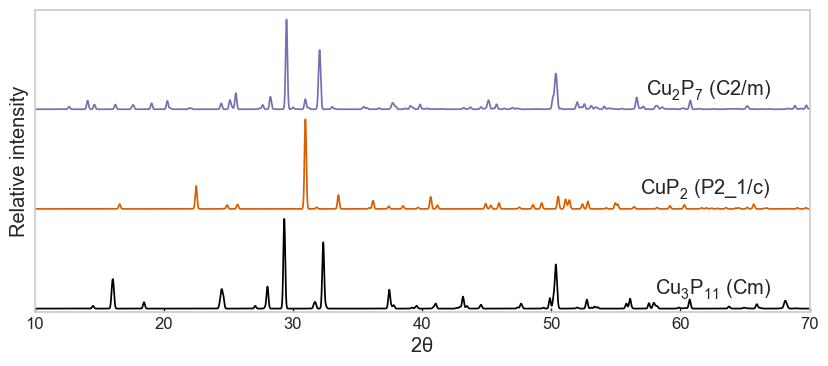

In [10]:
from matador.plotting import plot_pxrd
plot_pxrd([doc.pxrd for doc in cursor],
          figsize=(10,4),text_offset=0.15,
          png=True,
          labels=labels)

Using config from /u/fs1/afh41/.matadorrc
Reordering bands based on local gradients...


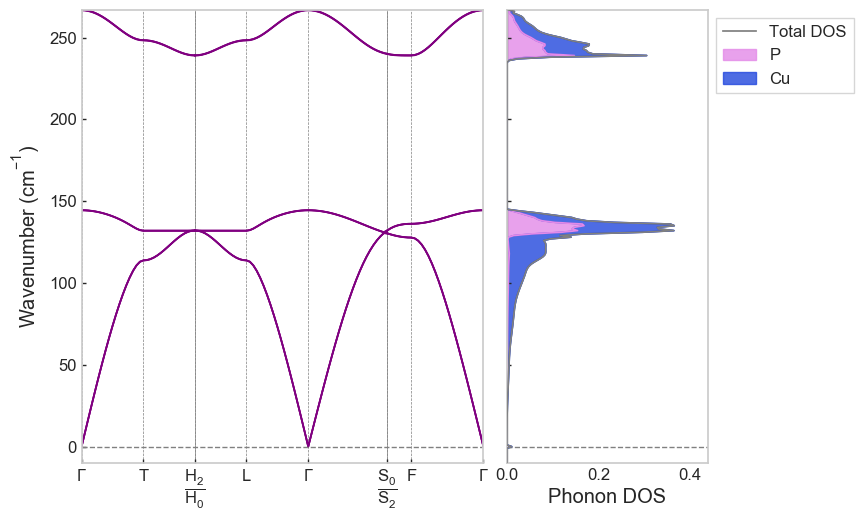

In [11]:
from matador.plotting import plot_spectral
ax = plot_spectral(
    '/u/fs1/afh41/Cu2P-phonon-correct-path/CuP-Ir2P-OQMD_30622-CollCode640898', 
    phonons=True,
    band_colour='purple', 
    png=True
)

Using config from /u/fs1/afh41/.matadorrc


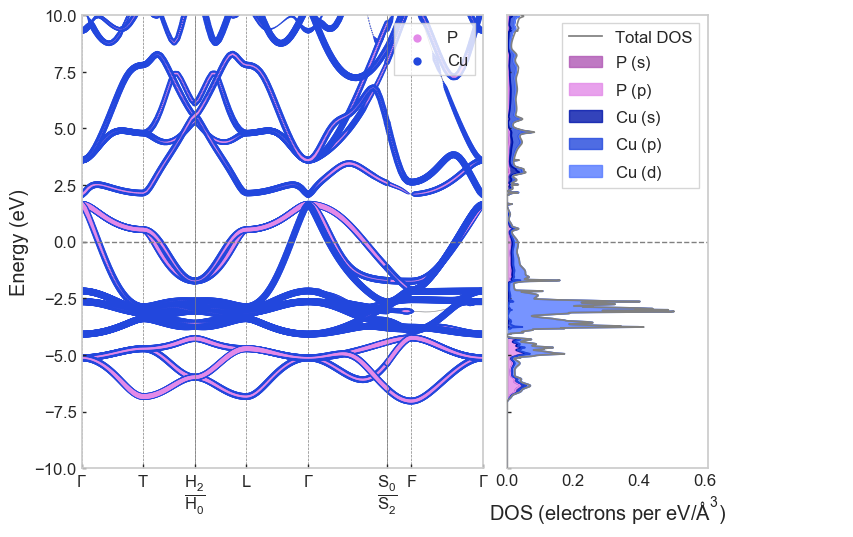

In [12]:
set_matplotlib_formats('png')
plot_spectral(
    '/u/fs1/afh41/Cu2P-bands-elec/CuP-Ir2P-OQMD_30622-CollCode640898',
    pdis_interpolation_factor=5,
    png=True
)
set_matplotlib_formats('png')

### Finite temperature stability

100%|██████████| 21/21 [00:00<00:00, 993.66it/s]

5 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.01       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]             -0.00       41.6          0.0   I4/mmm         Cu2P         1     SWAPS  
* CuP2-OQMD_6538-CollCode35282_0                 -0.00      391.9          0.0                  CuP2         4      ICSD  
* Cu2P7-OQMD_6537-CollCode35281_0                 0.05     1306.2          0.0                  Cu2P7 

Wrote CuP_hull21.png
Wrote CuPtemperature_hull.png


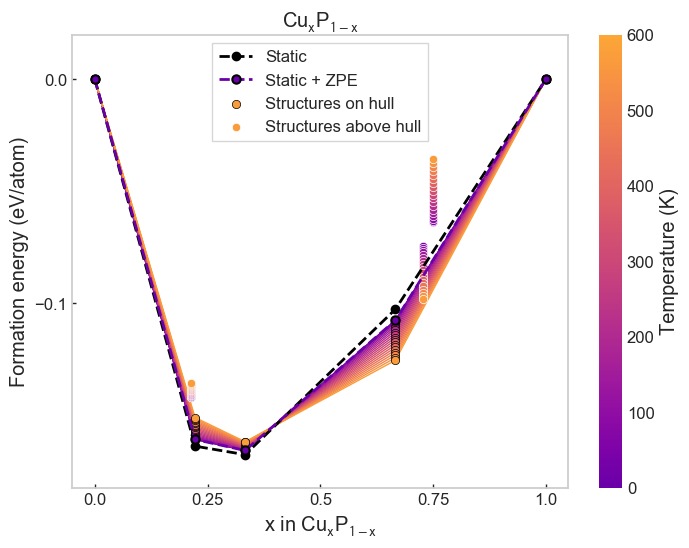

In [32]:
from matador.hull.hull_temperature import TemperatureDependentHull 
cursor, failures = castep2dict('/u/fs1/afh41/Cu3P-phonons/run3/completed/*.castep',db=False)
if failures:
    print(failures)
    
temperatures = np.linspace(0, 600, 21)
# me388 todo: add color bar to these plots
td_hull = TemperatureDependentHull(
    temperatures=temperatures,
    cursor=cursor,
    energy_key='total_energy_per_atom',
    species=['Cu','P'],
    png=True
)
ax = td_hull.plot_hull(plot_points=True)
lims = ax.get_ylim()
ax.set_ylim(lims[0], 0.02);

In [14]:
for doc in td_hull.cursor:
    if get_formula_from_stoich(doc['stoichiometry']) == 'Cu8P3':
        print(doc['hull_distance'])

0.009115996534057869


### Li-Cu-P ternary

In [15]:
cursor, failures = res2dict('/u/fs1/afh41/voltage-LiCuP-700eV/*.res', db=True)

if failures:
    print(failures)

In [16]:
# This is the ternary hull used to create the voltage profiles with a plane wave cutoff of 700 eV.
# It has ommitted the disputed Cu-Li phases and the high P content Cu-P phases to identify 
# specifically the Cu3P and Cu2P voltage profiles

ternary_hull = QueryConvexHull(cursor=cursor,
        expt='/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/Cu3P-expt-voltage-bichat2004electrochemicalC8.csv',
        expt_label='Cu$_3$P experimental Bichat et al (2004)',
        no_plot=True,
        capmap=True,
        pathways=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

11 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.03       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]              0.00       41.6          0.0    Immm          Cu2P         1     SWAPS  
* Cu2LiP2-OQMD_2275-CollCode2734                  0.01       72.5          0.0   I4/mmm        Cu2LiP2       1      ICSD  
* Cu4Li5P6-OQMD_33279-CollCode2735               -0.08      216.1          0.0    Immm        Cu4Li5P

In [17]:
# remove I43d Cu3P from cursor and plot with the ICSD P63cm Cu3P
noI43dCu3P = [doc for doc in cursor if (doc['stoichiometry'] != [['Cu',2],['P',1]])]
noI43dCu3P = [doc for doc in noI43dCu3P if doc['source'][0].split('/')[-1] != 'Cu3P-swap-AsCu3-OQMD_11878-CollCode64715.res']
        
hullnoI43dCu3P = QueryConvexHull(cursor=noI43dCu3P,
        no_plot=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

Something fishy with height above plane, returning 0...
0.0 0.0 0.0
[ 0.03337606  0.         -0.        ]
Something fishy with height above plane, returning 0...
0.0 0.75 -0.0333760624998618
[ 0.03337606  0.         -0.        ]
11 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.03       11.9          0.0    Fm-3m          Cu          1      ICSD  
* Cu3P-OQMD_2966-CollCode15056-OTF               -0.07       50.7          0.0   P6_3cm         Cu3P         6     SWA

Using config from /u/fs1/afh41/.matadorrc
Using config from /u/fs1/afh41/.matadorrc


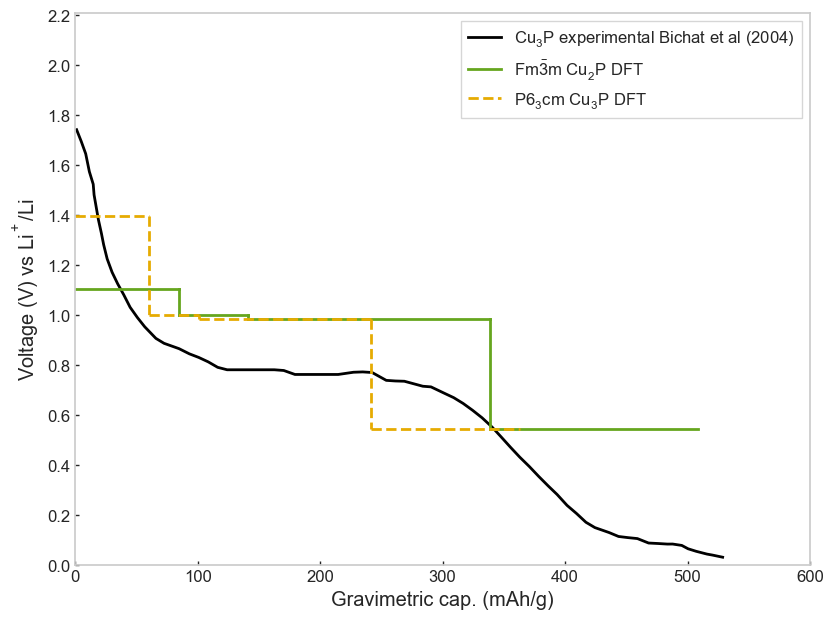

In [18]:
from matador.plotting import plot_voltage_curve
fig, ax = plt.subplots()
ax = plot_voltage_curve(ternary_hull, 
                        ax=ax, curve_label=r'$Fm\bar{3}m$ Cu$_2$P DFT', 
                        line_kwargs={'ls': '-', 'color': '#66a61e'})
ax = plot_voltage_curve(hullnoI43dCu3P, 
                        ax=ax, curve_label='$P6_3cm$ Cu$_3$P DFT', 
                        line_kwargs={'ls': '--', 'color': '#e6ab02'})
ax.set_xlim(left=0,right=600)
ax.legend()
plt.savefig('Cu2PCu3P_voltage.png',bbox_inches='tight',transparent=True)

### Supplementary Information

### Structural Similarity of Cu$_2$P and Cu$_3$P phases

Using config from /u/fs1/afh41/.matadorrc


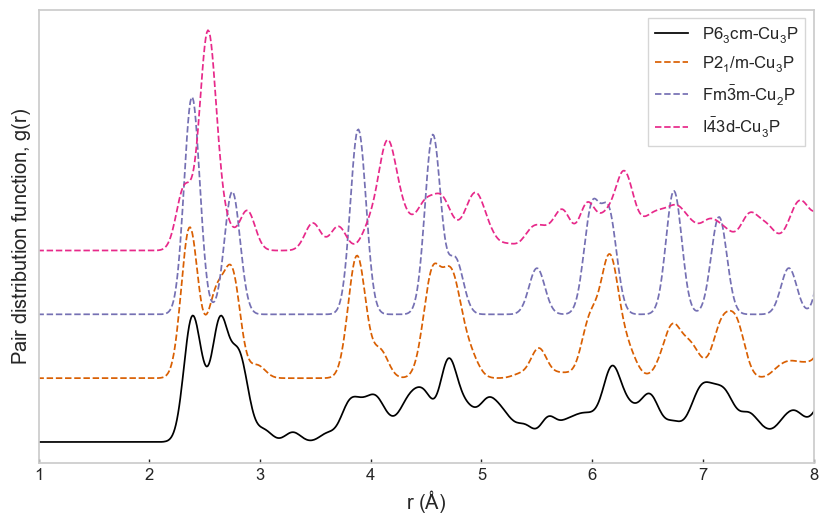

In [19]:
from matador.utils.cell_utils import get_space_group_label_latex
cursor, failures = res2dict('/u/fs1/afh41/Cu2-3P-phases/*.res', as_model=True)
cursor = [Crystal(doc) for doc in cursor]
P63 = cursor.pop(2)
cursor.insert(0,P63)
labels=[get_space_group_label_latex(get_spacegroup_spg(doc, symprec=0.01)).replace("\\text", "")+
        '-'+get_formula_from_stoich(doc['stoichiometry'],tex=True) for doc in cursor]

plot_pdf(cursor[0].pdf, other_pdfs=[doc.pdf for doc in cursor[1:]],
         labels=labels, 
         maxr=8,
         offset=30,
         png=True
)

Using config from /u/fs1/afh41/.matadorrc


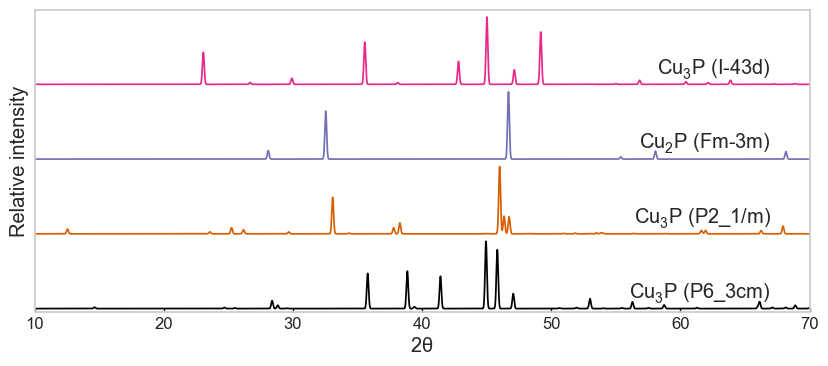

In [20]:
plot_pxrd([doc.pxrd for doc in cursor],figsize=(10,4),text_offset=0.15,
          png=True,
          labels=labels)

Using config from /u/fs1/afh41/.matadorrc


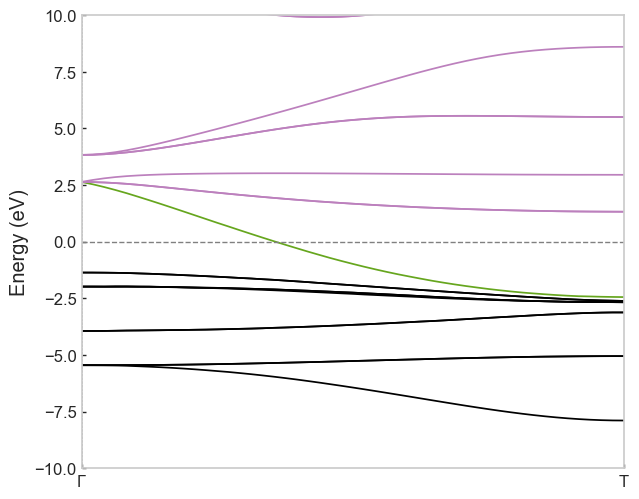

In [21]:
set_matplotlib_formats('png')
plot_spectral(
    '/u/fs1/afh41/Cu2P-bands-elec/HSE06/CuP-Ir2P-OQMD_30622-CollCode640898',
    plot_dos=False,
    png=True
)
set_matplotlib_formats('png')

Using config from /u/fs1/afh41/.matadorrc


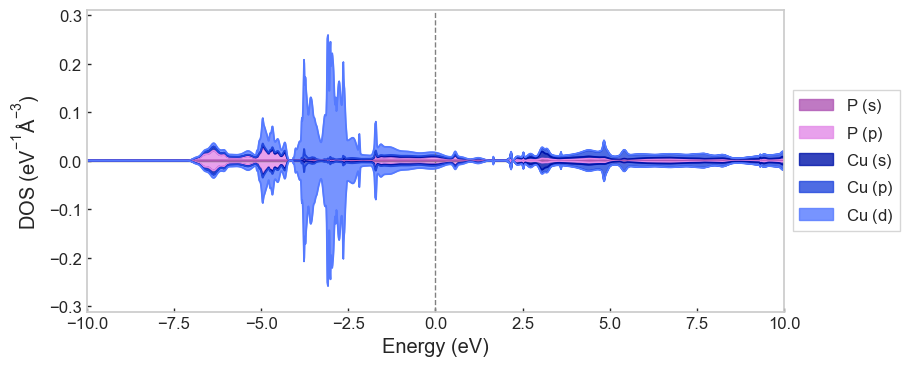

In [22]:
plot_spectral(
    '/u/fs1/afh41/Cu2P-bands-elec/SPIN/completed-spin/CuP-Ir2P-OQMD_30622-CollCode640898',
    plot_bandstructure=False,
    png=True
)
set_matplotlib_formats('png')

Using config from /u/fs1/afh41/.matadorrc


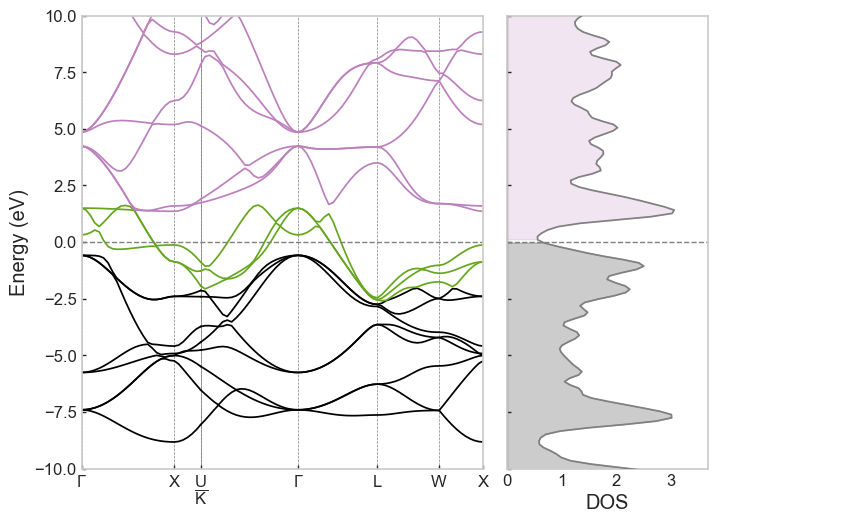

In [44]:
set_matplotlib_formats('png')
plot_spectral(
    '/u/fs1/afh41/Ir2P/Ir2P-OQMD_30622-CollCode640898',
    png=True
)

Using config from /u/fs1/afh41/.matadorrc


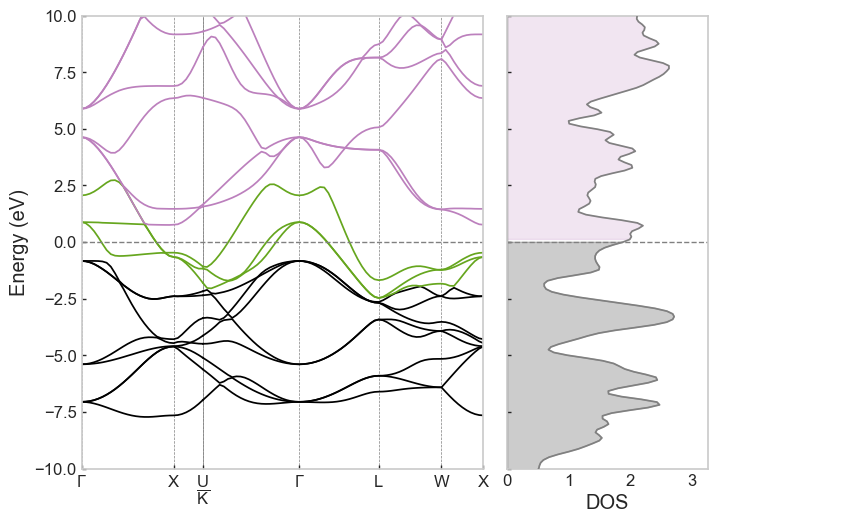

In [43]:
plot_spectral(
    '/u/fs1/afh41/Rh2P/PRh2-OQMD_7002-CollCode38356',
    png=True
    
)

In [25]:
# plot temperature vs. enthalpy for P and P_SCAN
from matador.orm.spectral import VibrationalDOS
P = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/P-CollCode150873_prim-out_prim.castep', db=False)[0])
P_SCAN = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/SCAN/P-CollCode150873_prim-out_prim.castep', db=False)[0])

Using config from /u/fs1/afh41/.matadorrc
Using config from /u/fs1/afh41/.matadorrc


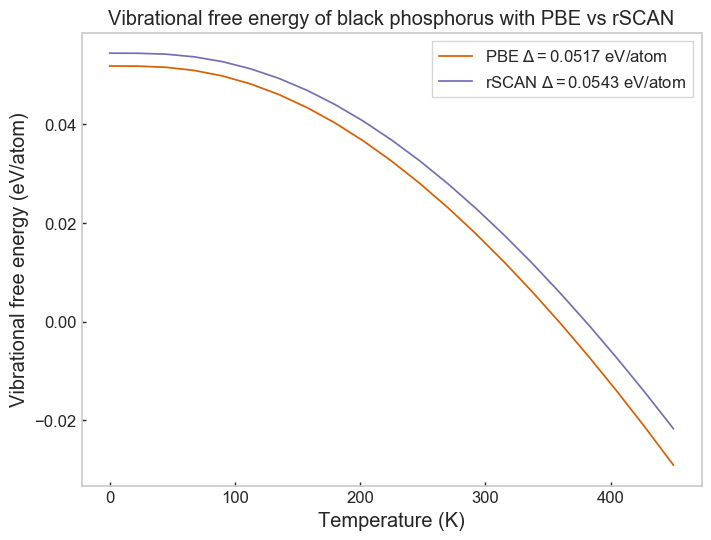

In [26]:
import numpy as np
temperatures = np.linspace(0, 450, 21)
fig, ax = plt.subplots()
ax.set_title('Vibrational free energy of black phosphorus with PBE vs rSCAN')
P.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': f'PBE $\\Delta={P.zpe:.4f}$ eV/atom','color':'#d95f02'})
P_SCAN.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': f'rSCAN $\\Delta={P_SCAN.zpe:.4f}$ eV/atom','color':'#7570b3'})
ax.legend()
plt.savefig('SCAN_PBE_compare.png',bbox_inches='tight',transparent=True)